In [129]:
import lightkurve as lk
import matplotlib.pyplot as plt
from IPython.display import HTML

import numpy as np

import sys
sys.path.append('../gefera')
import gefera as gf

(1513.5, 1514.1)

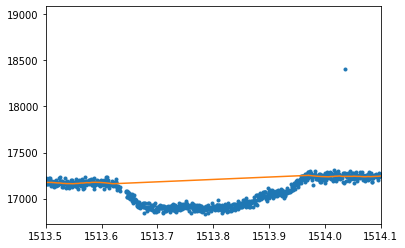

In [24]:
lcs = lk.search_lightcurve('Kepler-51')
lc_raw = lcs[27].download()
t_raw = lc_raw['time'].value
lc, trend = lc_raw.flatten(window_length=101, mask=(t_raw > 1513.62) & (t_raw < 1513.97), return_trend=True)
lc = lc.remove_outliers(sigma=10)
t = lc['time'].value
f = lc['flux'].value
plt.plot(t_raw, lc_raw['flux'].value, '.')
plt.plot(t_raw, trend.flux.value)
plt.xlim(1513.5, 1514.1)

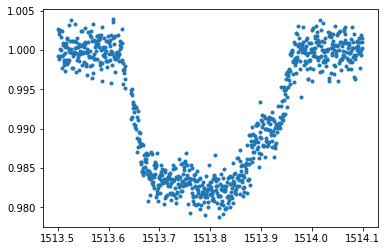

In [25]:
x = t[(t<1514.1) & (t>1513.5)]
y = f[(t<1514.1) & (t>1513.5)]
plt.plot(x, y, '.')

In [26]:
np.savetxt('k51.txt', np.vstack((x, y)).T)

CPU times: user 140 ms, sys: 6.33 ms, total: 146 ms
Wall time: 168 ms
-5146.209055043439


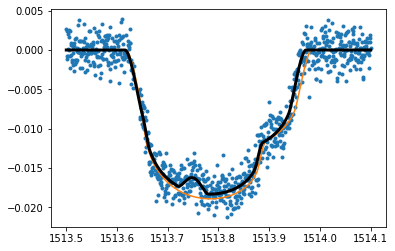

In [124]:
from scipy.optimize import minimize

a1 = 124.7 
t1 = 16.57
e1 = 0.00001
p1 = 130.194
w1 = 90.0 * np.pi / 180
b1 = 0.0
i1 = np.arccos(b1 / a1)
a1 = a1 * ac.R_sun.value / ac.au.value

a2 = 61.5 
t2 = 12.41
e2 = 0.00001
p2 = 45.154
w2 = 0.1 * np.pi / 180
om2 = 155 * np.pi / 180
b2 = 0.0
i2 = np.arccos(b2 / a2)
a2 = a2 * ac.R_sun.value / ac.au.value

u1 = 0.5
u2 = 0.3
r1 = 0.1
r2 = 0.07

o1 = gf.PrimaryOrbit(a1, t1, e1, p1, w1, i1)
o2 = gf.ConfocalOrbit(a2, t2, e2, p2, om2, w2, i2)
sys = gf.ConfocalSystem(o1, o2)
plt.plot(x, y - 1, '.')
plt.plot(x, sys.lightcurve(x, u1, u2, r1, r2))

bounds = [
    (0.001, 0.003),
    (None, None),
    (None, None),
    (1e-10, 1),
    (None, None),
    (None, None),
    (None, None),
    (None, None),
    (None, None),
    (1e-10, 1),
    (None, None),
    (None, None),
    (None, None),
    (None, None),
    (0, 1),
    (0, 1),
    (0, 1),
    (0, 1)
]

def fun_jac(args):
    sigma, a1, t1, e1, p1, w1, i1, a2, t2, e2, p2, om2, w2, i2, r1, r2, u1, u2 = args
    o1 = gf.PrimaryOrbit(a1, t1, e1, p1, w1, i1)
    o2 = gf.ConfocalOrbit(a2, t2, e2, p2, om2, w2, i2)
    sys = gf.ConfocalSystem(o1, o2)
    ll, dll = sys.loglike(y - 1, x, u1, u2, r1, r2, sigma, grad=True, sign=-1)
    return ll, dll

x0 = [0.0016, a1, t1, e1, p1, w1, i1, a2, t2, e2, p2, om2, w2, i2, r1, r2, u1, u2]

%time res = minimize(fun_jac, x0, jac=True, method='TNC', bounds=bounds)
print(fun_jac(res.x)[0])

sigma, a1, t1, e1, p1, w1, i1, a2, t2, e2, p2, om2, w2, i2, r1, r2, u1, u2 = res.x
o1 = gf.PrimaryOrbit(a1, t1, e1, p1, w1, i1)
o2 = gf.ConfocalOrbit(a2, t2, e2, p2, om2, w2, i2)
sys = gf.ConfocalSystem(o1, o2)
lc = sys.lightcurve(x, u1, u2, r1, r2, grad=False)

plt.plot(x, lc, color='k', linewidth=3)

In [125]:
uniform = lambda x, l, u: 0.0 if ((x >= l) & (x <= u)) else -np.inf

def log_prior(args):
    
    lsigma, r1, r2, u1, u2, a1, t1, le1, p1, lw1, i1, a2, t2, le2, p2, om2, lw2, i2 = args
    
    prior = 0.0 if r2 < r1 and u1 + u2 < 1 and u1 > 0 and u1 + 2 * u2 > 0 else -np.inf
    
    return (prior 
            + uniform(lsigma, np.log(0.001), np.log(0.003))
            + uniform(r1, 0.09, 0.5)
            + uniform(r2, 0.0, 0.09)
            + uniform(a1, 100 * ac.R_sun.value / ac.au.value, 200 * ac.R_sun.value / ac.au.value)
            + uniform(t1, 0.0, 30.0)
            + uniform(le1, -np.inf, 0.0)
            + uniform(p1, 100, 200)
            + uniform(lw1, -np.inf, np.log(np.pi))
            + uniform(i1, 85 * np.pi / 180, 95 * np.pi / 180)
            + uniform(a2, 10.0 * ac.R_sun.value / ac.au.value, 100.0 * ac.R_sun.value / ac.au.value)
            + uniform(t2, 0.0, 30.0)
            + uniform(le2, -np.inf, 0.0)
            + uniform(p2, 0.0, 100.0)
            + uniform(om2, 0.0, np.pi)
            + uniform(lw2, -np.inf, np.log(np.pi))
            + uniform(i2, 85 * np.pi / 180, 95 * np.pi / 180)
    )

def log_like(args, y):
    
    lsigma, r1, r2, u1, u2, a1, t1, le1, p1, lw1, i1, a2, t2, le2, p2, om2, lw2, i2 = args
    o1 = gf.PrimaryOrbit(a1, t1, np.exp(le1), p1, np.exp(lw1), i1)
    o2 = gf.ConfocalOrbit(a2, t2, np.exp(le2), p2, om2, np.exp(lw2), i2)
    sys = gf.ConfocalSystem(o1, o2)
    return sys.loglike(y, x, u1, u2, r1, r2, np.exp(lsigma))

def log_prob(args, y):
    lp = log_prior(args)
    ll = log_like(args, y)
    if np.isfinite(ll):
        return lp + ll
    else:
        return -np.inf

In [126]:
#init_params = [np.log(0.002), r1, r2, 0.5, 0.3, a1, t1, np.log(e1), p1, np.log(w1), i1, a2, t2, np.log(e2), p2, om2, np.log(w2), i2]

def transform_init(args):
    sigma, a1, t1, e1, p1, w1, i1, a2, t2, e2, p2, om2, w2, i2, r1, r2, u1, u2 = args
    lsigma = np.log(sigma)
    lw1 = np.log(w1)
    lw2 = np.log(w2)
    le1 = np.log(e1)
    le2 = np.log(e2)
    return lsigma, r1, r2, u1, u2, a1, t1, le1, p1, lw1, i1, a2, t2, le2, p2, om2, lw2, i2

init_params = transform_init(res.x)
log_prior(init_params)

0.0

In [127]:
import emcee

#init_params = flat_samples[np.random.randint(len(flat_samples))]
pos = init_params + 1e-3 * np.random.randn(100, len(init_params))
#init = flat_samples[np.random.randint(len(flat_samples), size=1000)]
#pos = init_params + 1e-3 * np.random.randn(1000, len(init_params))

nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_prob, args=(y - 1,)
)
sampler.run_mcmc(pos, 50000, progress=True);

 18%|█▊        | 8755/50000 [07:28<29:35, 23.23it/s]  <ipython-input-125-a81a2498c93f>:31: RuntimeWarning: overflow encountered in exp
  o1 = gf.PrimaryOrbit(a1, t1, np.exp(le1), p1, np.exp(lw1), i1)
 34%|███▍      | 17034/50000 [14:13<23:50, 23.04it/s]  <ipython-input-125-a81a2498c93f>:32: RuntimeWarning: overflow encountered in exp
  o2 = gf.ConfocalOrbit(a2, t2, np.exp(le2), p2, om2, np.exp(lw2), i2)
100%|██████████| 50000/50000 [41:41<00:00, 19.98it/s]  


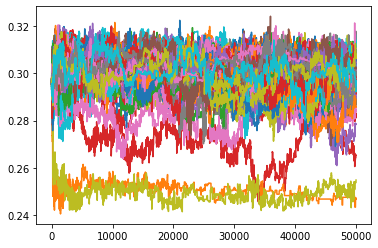

In [123]:
chains = sampler.get_chain()
plt.plot(chains[:, :, 11]);

In [ ]:
mask = np.mean(sampler.get_chain(discard=5000, thin=10)[:, :, 1], axis=0) < 0.11

In [ ]:
chains = sampler.get_chain(discard=1000, thin=10)[:, mask, :]
chains = np.reshape(chains, (np.shape(chains)[0]*np.shape(chains)[1], np.shape(chains)[2]))

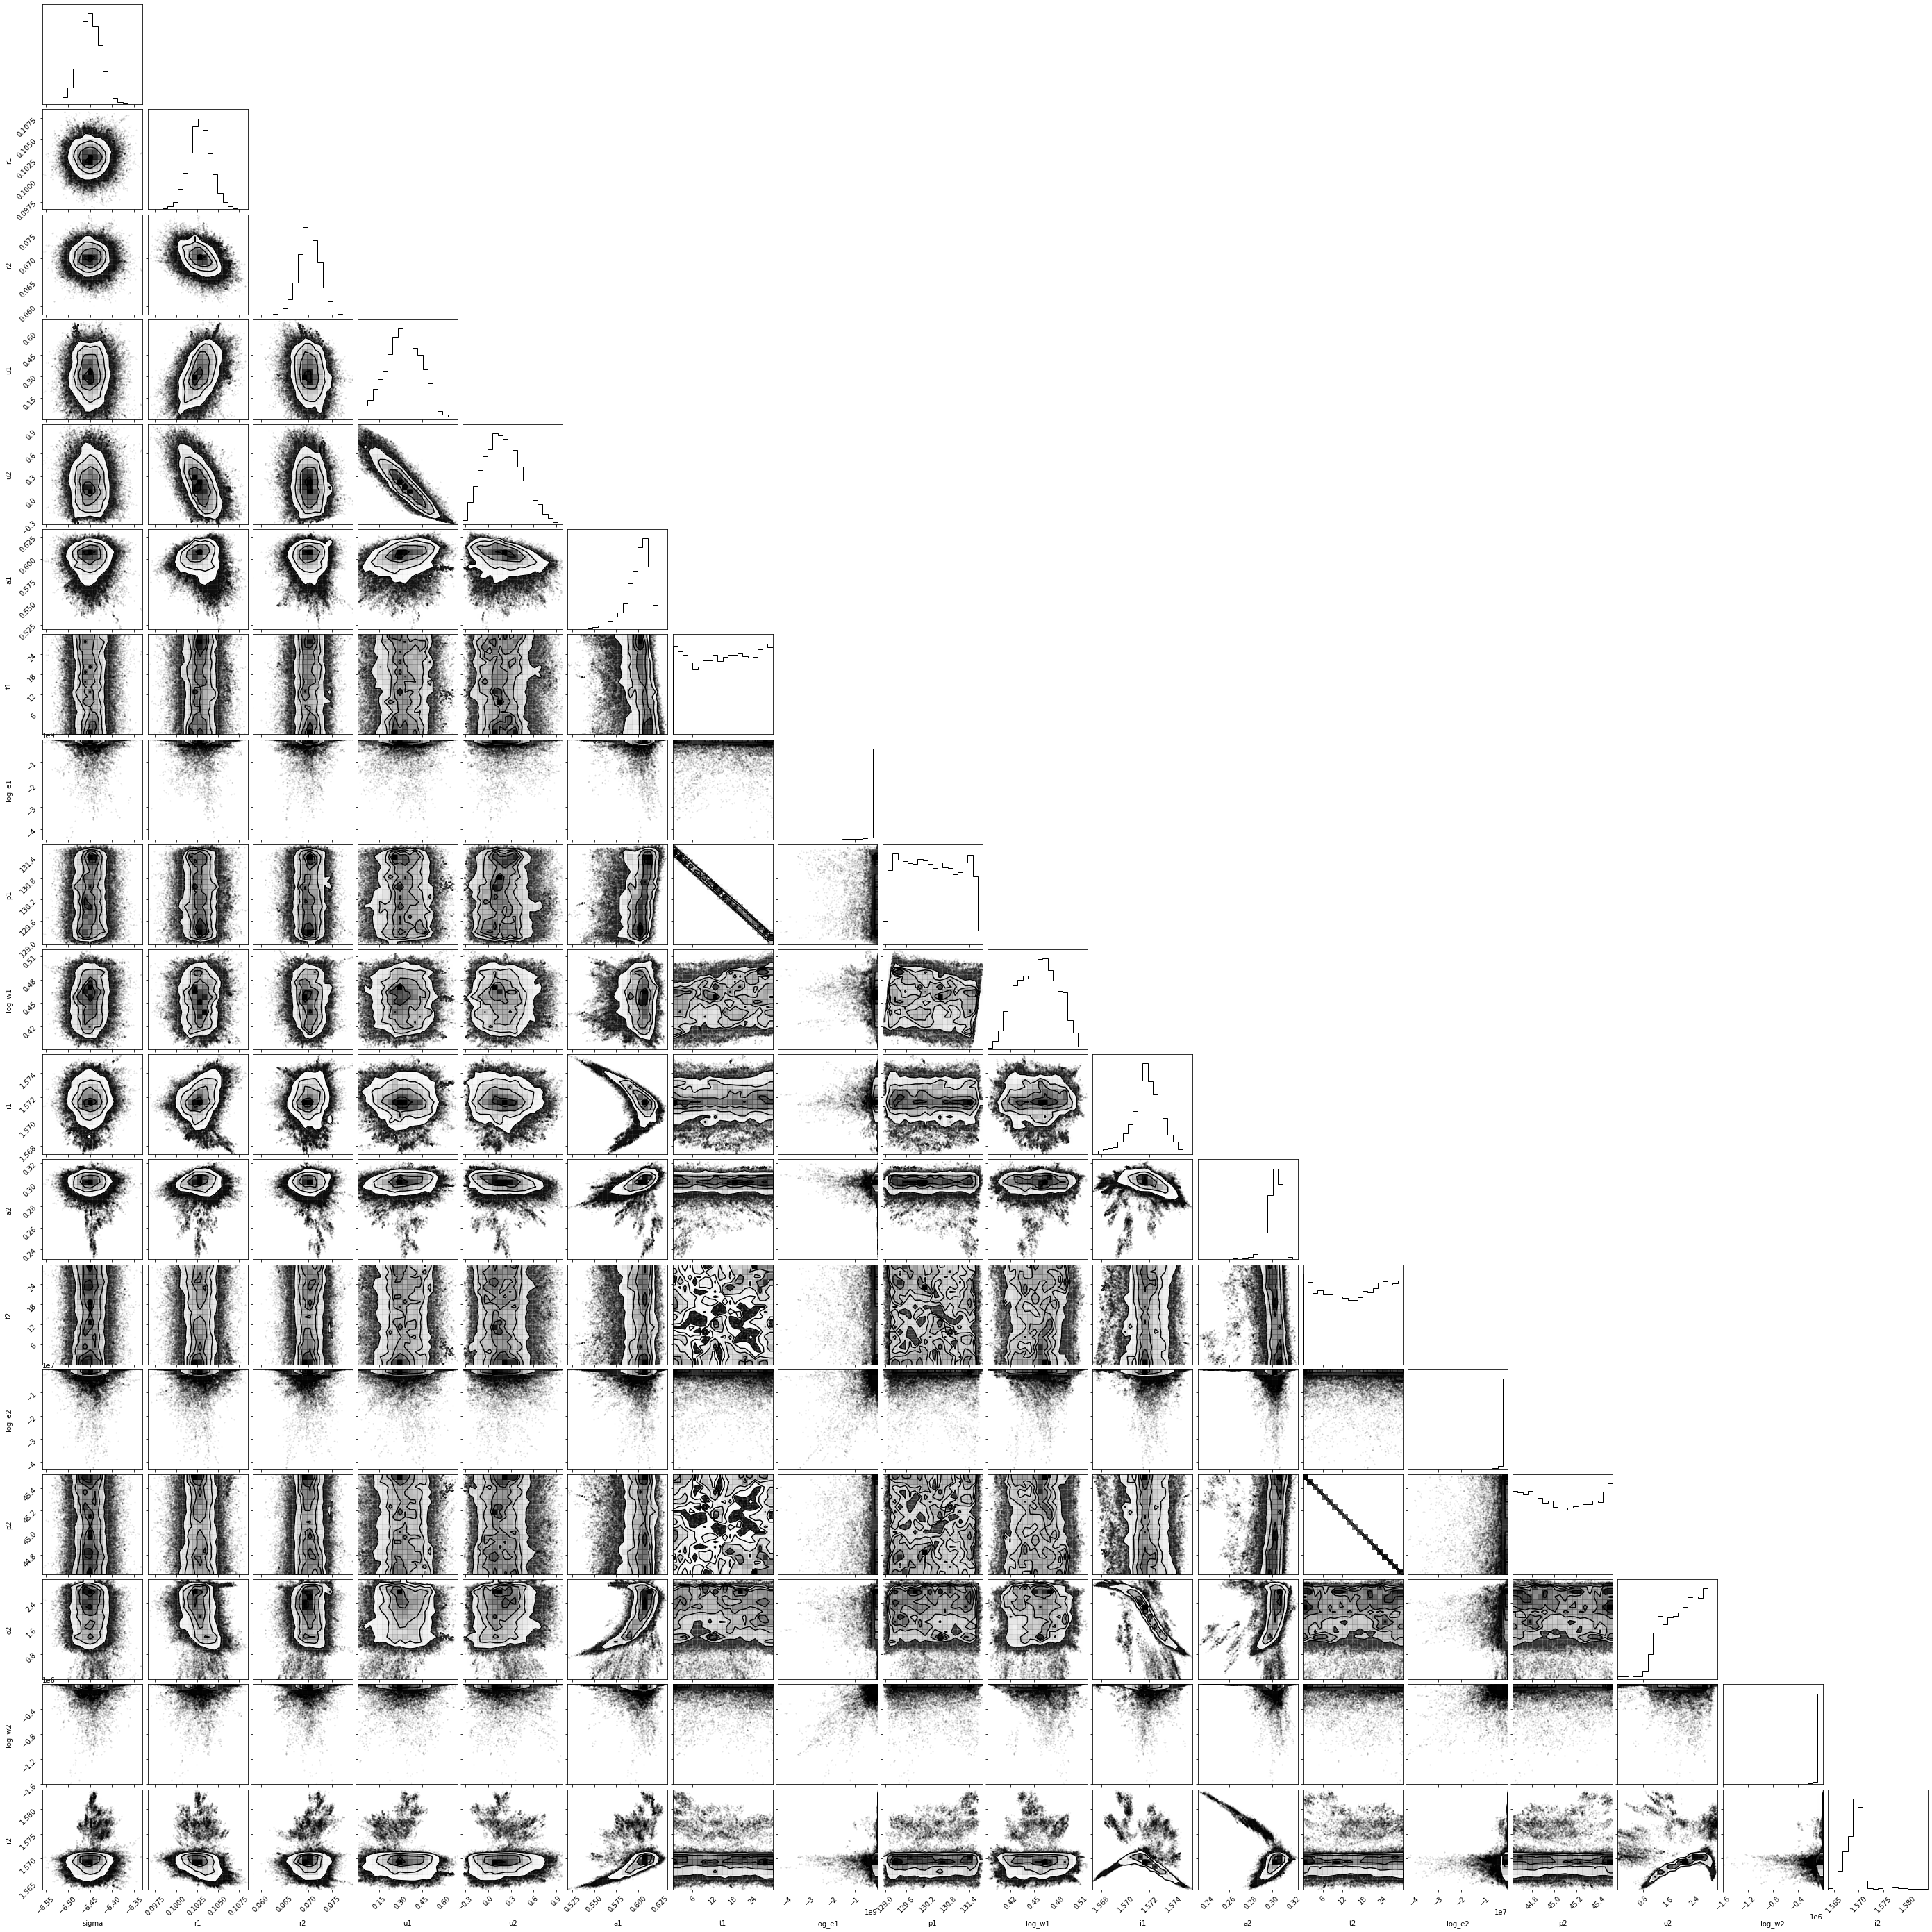

In [128]:
import corner

flat_samples = sampler.get_chain(discard=10000, thin=20, flat=True)
fig = corner.corner(
    flat_samples, 
    labels=[
        'sigma', 
        'r1', 
        'r2', 
        'u1', 
        'u2', 
        'a1', 
        't1', 
        'log_e1', 
        'p1', 
        'log_w1', 
        'i1', 
        'a2', 
        't2', 
        'log_e2', 
        'p2', 
        'o2', 
        'log_w2', 
        'i2', 
    ]
);

plt.savefig('/Users/tgordon/Desktop/corner_kep_51.pdf')

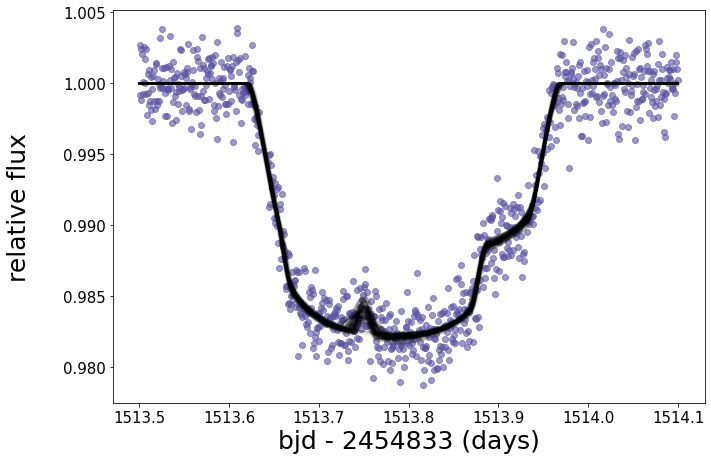

In [107]:
from IPython.display import HTML
import animate

n = 100
inds = np.random.randint(len(flat_samples), size=n)
samps = flat_samples[inds]


def getlc(*args):
    _, r1, r2, u1, u2, a1, t1, le1, p1, lw1, i1, a2, t2, le2, p2, om2, lw2, i2 = args
    o1 = gf.PrimaryOrbit(a1, t1, np.exp(le1), p1, np.exp(lw1), i1)
    o2 = gf.ConfocalOrbit(a2, t2, np.exp(le2), p2, om2, np.exp(lw2), i2)
    sys = gf.ConfocalSystem(o1, o2)
    return sys.lightcurve(x, u1, u2, r1, r2)

def animate_sample(fig, *args):
    _, r1, r2, u1, u2, a1, t1, le1, p1, lw1, i1, a2, t2, le2, p2, om2, lw2, i2 = args
    o1 = gf.PrimaryOrbit(a1, t1, np.exp(le1), p1, np.exp(lw1), i1)
    o2 = gf.ConfocalOrbit(a2, t2, np.exp(le2), p2, om2, np.exp(lw2), i2)
    sys = gf.ConfocalSystem(o1, o2)
    
    return animate.animate(sys, fig, x[::10], r1, r2, ld_params=(u1, u2))

plt.figure(figsize=(10, 7))
plt.plot(x, y, 'o', color=plt.cm.Spectral(0.99), alpha=0.6)
for i in range(n):
    samp = getlc(*samps[i])
    plt.plot(x, samp + 1, color='k', linewidth=2, alpha=0.1)
    
plt.ylabel('relative flux\n', fontsize=25)
plt.xlabel('bjd - 2454833 (days)', fontsize=25)
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig('/Users/tgordon/Desktop/kep51_samples.pdf')

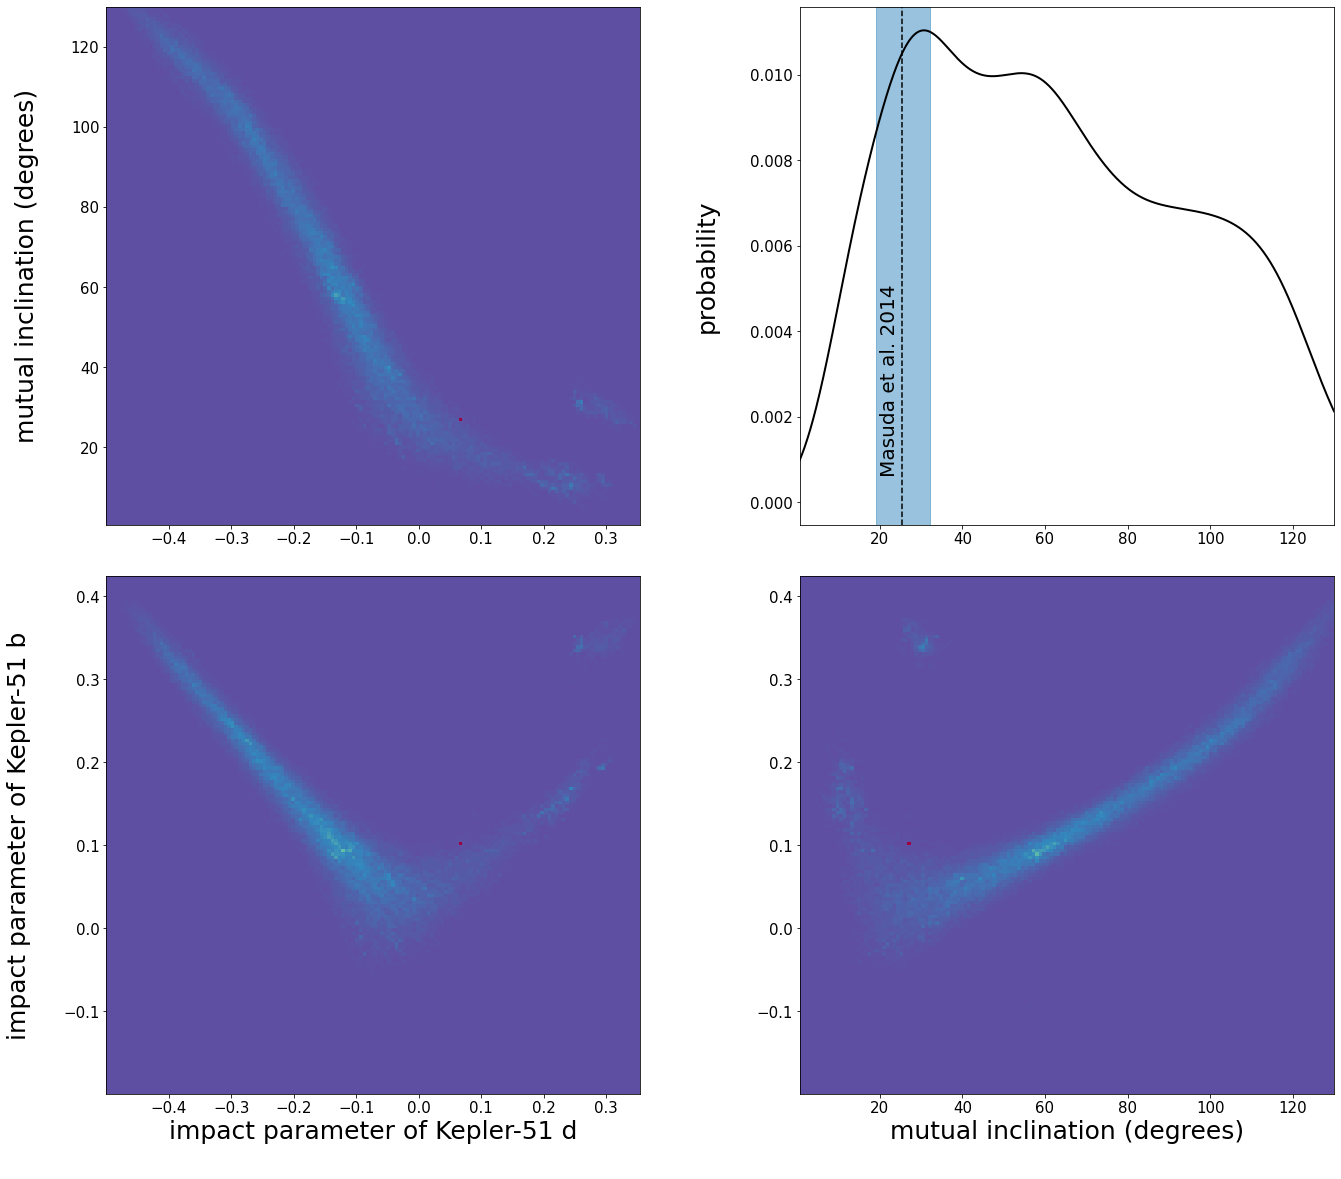

In [108]:
import matplotlib as mpl
from scipy import stats

fig, axs = plt.subplots(2, 2, figsize=(22, 20))

au_r = 215.03215567054764

inc1 = flat_samples[:, 10]
a1 = flat_samples[:, 5]
b1 = a1 * np.cos(inc1) * au_r

inc2 = flat_samples[:, 17]
a2 = flat_samples[:, 11]
b2 = a2 * np.cos(inc2) * au_r

mut_inc = 180 - flat_samples[:, 15] * 180 / np.pi

mask = (b2 < 0.8) & (mut_inc < 130) & (b2 > -0.2)
b1 = b1[mask]
b2 = b2[mask]
mut_inc = mut_inc[mask]

counts, ybins, xbins, _ = axs[0, 0].hist2d( 
    b1, 
    mut_inc,
    bins=150,
    density=True,
    cmap=plt.cm.Spectral_r,
    rasterized=True
);
counts, ybins, xbins, _ = axs[1, 1].hist2d(
    mut_inc, 
    b2, 
    bins=150,
    density=True,
    cmap=plt.cm.Spectral_r,
    rasterized=True
);
counts, ybins, xbins, _ = axs[1, 0].hist2d(
    b1, 
    b2, 
    bins=150,
    density=True,
    cmap=plt.cm.Spectral_r,
    rasterized=True
);

kernel = stats.gaussian_kde(180 - flat_samples[:, 15] * 180 / np.pi, bw_method=0.2)
xx = np.linspace(-10, 130, 1000)
yy = kernel(xx)
axs[0, 1].plot(xx, yy, color='k', linewidth=2)
axs[0, 1].axvline(25.3, color='k', linestyle='--')
axs[0, 1].axvspan(25.3-6.2, 25.3+6.8, color=plt.cm.Spectral(0.9), alpha=0.5)
axs[0, 1].annotate('Masuda et al. 2014', fontsize=20, xy=(0.15, 0.1), xycoords='axes fraction', rotation=90)

#axs[1, 0].annotate("A", fontsize=30, xy=(0.1, 0.1), xycoords='axes fraction', color='w')
#axs[1, 0].annotate("B", fontsize=30, xy=(0.5, 0.45), xycoords='axes fraction', color='w')
#axs[1, 0].annotate("C", fontsize=30, xy=(0.5, 0.65), xycoords='axes fraction', color='w')

[ax.tick_params(axis='both', which='major', labelsize=15) for ax in axs.flatten()]

axs[1, 0].set_ylabel('impact parameter of Kepler-51 b\n', fontsize=25)

axs[1, 0].set_xlabel('impact parameter of Kepler-51 d\n', fontsize=25)
axs[0, 0].set_ylabel('mutual inclination (degrees)\n', fontsize=25)

axs[1, 1].set_ylabel(None)
axs[1, 1].set_xlabel('mutual inclination (degrees)', fontsize=25)
axs[0, 1].set_ylabel('probability\n', fontsize=25)

axs[0, 1].set_xlim(axs[1, 1].get_xlim())

plt.subplots_adjust(wspace=0.3, hspace=0.1)

plt.savefig('/Users/tgordon/Desktop/kep51_posterior.pdf')

In [ ]:
n = 100

b1max, b2max, b1min, b2min = 0.3, 0.38, 0.18, 0.3
mask2 = (b1 < b1max) & (b1 > b1min) & (b2 > b2min) & (b2 < b2max)
mode2_samples = flat_samples[mask][mask2]

inds = np.random.randint(len(mode2_samples), size=n)
samps = mode2_samples[inds]


def getlc(*args):
    _, r1, r2, u1, u2, a1, t1, e1, p1, w1, i1, a2, t2, e2, p2, om2, w2, i2 = args
    o1 = gf.PrimaryOrbit(a1, t1, e1, p1, w1, i1)
    o2 = gf.ConfocalOrbit(a2, t2, e2, p2, om2, w2, i2)
    sys = gf.ConfocalSystem(o1, o2)
    return sys.lightcurve(x, u1, u2, r1, r2)

fig, axs = plt.subplots(1, 3, figsize=(33, 10))
axs[1].plot(x, y, 'o', color=plt.cm.Spectral(0.99), alpha=0.6)
for i in range(n):
    samp = getlc(*samps[i])
    axs[1].plot(x, samp + 1, color='k', linewidth=0.5, alpha=0.6)
    
counts, ybins, xbins, _ = axs[0].hist2d(
    b1, 
    b2, 
    bins=100,
    density=True,
    cmap=plt.cm.Spectral_r,
);

axs[2].hist(mut_inc[mask2][mut_inc[mask2] < 120], bins=20, density=True, histtype='step', linewidth=3, color='k')

rect = plt.Rectangle((b1min, b2min), b1max-b1min, b2max-b2min, fill=False, color='k', linewidth=3)
axs[0].add_patch(rect)

axs[0].set_xlabel('impact parameter for Kepler-51 b', fontsize=25)
axs[0].set_ylabel('impact parameter for Kpler-51 d\n', fontsize=25)
axs[1].set_ylabel('relative flux\n', fontsize=25)
axs[1].set_xlabel('bjd - 2454833 (days)', fontsize=25)
[ax.tick_params(axis='both', which='major', labelsize=15) for ax in axs]

plt.subplots_adjust(wspace=0.3)

plt.savefig('/Users/tgordon/Desktop/mode2.pdf')

In [ ]:
n = 100

b1max, b2max, b1min, b2min = 0.0, 0.18, -0.2, 0.0
mask1 = (b1 < b1max) & (b1 > b1min) & (b2 > b2min) & (b2 < b2max)
mode1_samples = flat_samples[mask][mask1]

inds = np.random.randint(len(mode1_samples), size=n)
samps = mode1_samples[inds]


def getlc(*args):
    _, r1, r2, u1, u2, a1, t1, e1, p1, w1, i1, a2, t2, e2, p2, om2, w2, i2 = args
    o1 = gf.PrimaryOrbit(a1, t1, e1, p1, w1, i1)
    o2 = gf.ConfocalOrbit(a2, t2, e2, p2, om2, w2, i2)
    sys = gf.ConfocalSystem(o1, o2)
    return sys.lightcurve(x, u1, u2, r1, r2)

fig, axs = plt.subplots(1, 3, figsize=(33, 10))
axs[1].plot(x, y, 'o', color=plt.cm.Spectral(0.99), alpha=0.6)
for i in range(n):
    samp = getlc(*samps[i])
    axs[1].plot(x, samp + 1, color='k', linewidth=0.5, alpha=0.6)
    
counts, ybins, xbins, _ = axs[0].hist2d(
    b1, 
    b2, 
    bins=100,
    density=True,
    cmap=plt.cm.Spectral_r,
);

axs[2].hist(mut_inc[mask3][mut_inc[mask3] < 120], bins=20, density=True, histtype='step', linewidth=3, color='k')

rect = plt.Rectangle((b1min, b2min), b1max-b1min, b2max-b2min, fill=False, color='k', linewidth=3)
axs[0].add_patch(rect)

axs[0].set_xlabel('impact parameter for Kepler-51 b', fontsize=25)
axs[0].set_ylabel('impact parameter for Kpler-51 d\n', fontsize=25)
axs[1].set_ylabel('relative flux\n', fontsize=25)
axs[1].set_xlabel('bjd - 2454833 (days)', fontsize=25)
[ax.tick_params(axis='both', which='major', labelsize=15) for ax in axs]

plt.subplots_adjust(wspace=0.3)

plt.savefig('/Users/tgordon/Desktop/mode1.pdf')

In [ ]:
n = 100

b1max, b2max, b1min, b2min = 0.32, 0.52, 0.22, 0.42
mask3 = (b1 < b1max) & (b1 > b1min) & (b2 > b2min) & (b2 < b2max)
mode3_samples = flat_samples[mask][mask3]

inds = np.random.randint(len(mode3_samples), size=n)
samps = mode3_samples[inds]


def getlc(*args):
    _, r1, r2, u1, u2, a1, t1, e1, p1, w1, i1, a2, t2, e2, p2, om2, w2, i2 = args
    o1 = gf.PrimaryOrbit(a1, t1, e1, p1, w1, i1)
    o2 = gf.ConfocalOrbit(a2, t2, e2, p2, om2, w2, i2)
    sys = gf.ConfocalSystem(o1, o2)
    return sys.lightcurve(x, u1, u2, r1, r2)

fig, axs = plt.subplots(1, 3, figsize=(33, 10))
axs[1].plot(x, y, 'o', color=plt.cm.Spectral(0.99), alpha=0.6)
for i in range(n):
    samp = getlc(*samps[i])
    axs[1].plot(x, samp + 1, color='k', linewidth=0.5, alpha=0.6)
    
counts, ybins, xbins, _ = axs[0].hist2d(
    b1, 
    b2, 
    bins=100,
    density=True,
    cmap=plt.cm.Spectral_r,
);

axs[2].hist(mut_inc[mask3][mut_inc[mask3] < 120], bins=20, density=True, histtype='step', linewidth=3, color='k')

rect = plt.Rectangle((b1min, b2min), b1max-b1min, b2max-b2min, fill=False, color='k', linewidth=3)
axs[0].add_patch(rect)

axs[0].set_xlabel('impact parameter for Kepler-51 b', fontsize=25)
axs[0].set_ylabel('impact parameter for Kpler-51 d\n', fontsize=25)
axs[1].set_ylabel('relative flux\n', fontsize=25)
axs[1].set_xlabel('bjd - 2454833 (days)', fontsize=25)
[ax.tick_params(axis='both', which='major', labelsize=15) for ax in axs]

plt.subplots_adjust(wspace=0.3)

plt.savefig('/Users/tgordon/Desktop/mode3.pdf')